#  Gaussian network for two clusters graph 

##  Generate Network and Signals 

In [1]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
import networkx as nx
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import os
from time import gmtime, strftime
import scipy as sp
import cvxopt
from sklearn.linear_model import lars_path
%matplotlib inline 

In [2]:
from latent_signal_network import latent_signal_network as lsn 

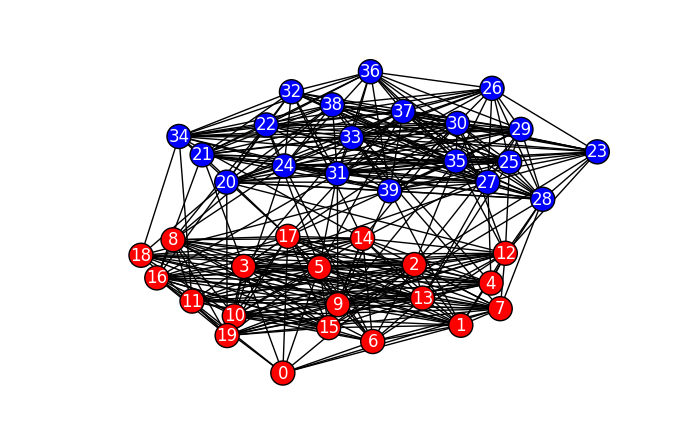

In [3]:
savefigure = False
seed = 1000
choice = 'partition'
d = 12
if choice == 'newman':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['k-NN'] = 2
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'partition':
    size = [20, 20]
    prob = [0.8, 0.15]
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['cutoff_freq'] = 12
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'grid':
    size = [4, 5]
    prob = 0.6
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
elif choice == 'binomial':
    size = 20
    prob = 0.18

    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
    
elif choice == 'tree':
    size = 20
    gamma = 3
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'gamma': gamma ,'model': choice}
    option['cutoff_freq'] = 10
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
    
elif choice == 'balanced_tree':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['r'] = 2
    option['h'] = 3
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)    

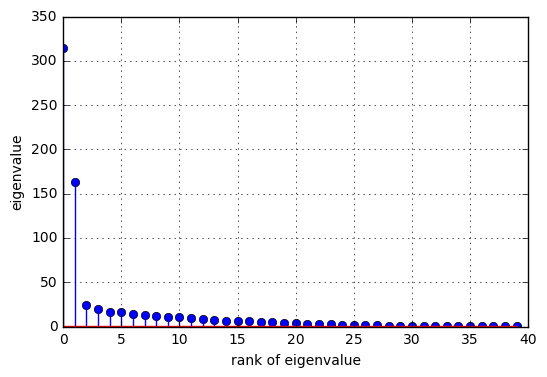

In [4]:
#Plot the eigenvalue of adjacency matrix
adjMat =  nx.adjacency_matrix(G0).todense()
Sigma, U = np.linalg.eigh(np.dot(adjMat, adjMat))
index_sig = np.argsort(Sigma)
Sigma = Sigma[index_sig[::-1]]
U = U[:,index_sig[::-1]]

fig3 =plt.figure(3)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(Sigma)), Sigma, 'b', basefmt='k-')
plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlabel('rank of eigenvalue')
plt.ylabel('eigenvalue')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_adjMat.eps"
if savefigure : fig3.savefig(filename)

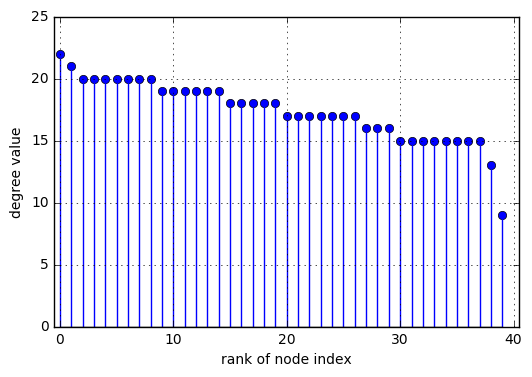

In [5]:
degrees = G0.degree()
degree_val = np.array(list(degrees.values()))
degree_node = np.array(list(degrees.keys()))
deg_idx = list(np.argsort(degree_val))

degree_val = degree_val[deg_idx[::-1]]
degree_node = degree_node[deg_idx[::-1]]

fig5 =plt.figure(5)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(degree_node)), degree_val, 'b', basefmt='k-')
#plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlim(-0.5, len(degree_val)+0.5)
plt.xlabel('rank of node index')
plt.ylabel('degree value')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_degree_dist.eps"
if savefigure : fig5.savefig(filename)

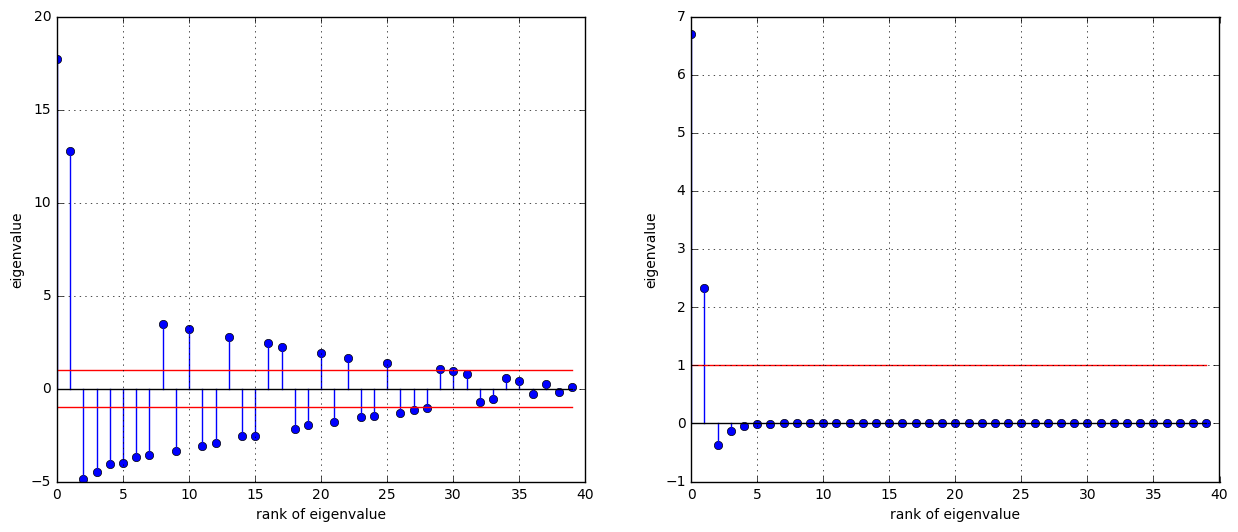

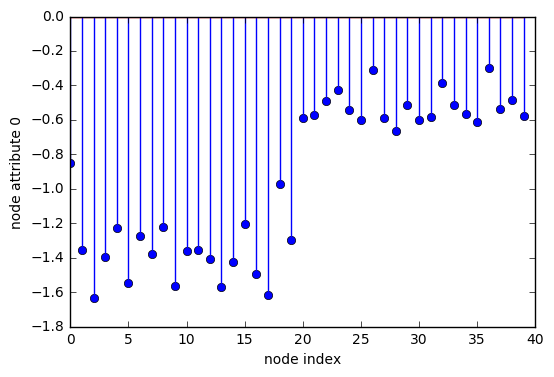

In [6]:
Tmax = 1
option_sig = {}
option_sig['mat'] = 'adjacency_matrix'
choice2 = 'sigmoid' #'polynomial'

if choice2 == 'l1_threshold':
    option_sig['method'] = choice2
    option_sig['threshold'] = 0.5
elif choice2 == 'polynomial':
    option_sig['method'] = choice2
    degree_val = np.array(list(G0.degree().values()))
    bias = 1/np.sqrt(np.mean(degree_val))
    option_sig['coeffs'] = [bias, -2, 1]
elif choice2 == 'rescale':
    option_sig['method'] = choice2
    option_sig['weights'] = np.random.rand((len(G0),))
elif choice2 == 'sigmoid':
    option_sig['method'] = choice2
    option_sig['rate'] = 1
    option_sig['shift'] = 0.5
    option_sig['bias'] = 0
    
     
    
G0_node, X0, _= LSN.smooth_gsignal_filter(G0, option_sig, sigma=10, seed=10, add_noise=False, show_plot=True, save_fig=savefigure)
#G0_node, X0, hist_tv = LSN.smooth_gsignal_generate(G0, T=Tmax, sigma=10, alpha=0.2, seed=10, add_noise=False, overwrite=True)
fig1 = plt.figure(1)
plt.stem(np.arange(X0.shape[0]),X0[:,0])
plt.xlabel('node index')
plt.ylabel('node attribute 0')
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_node_fea0.eps"
if savefigure : fig1.savefig(filename)

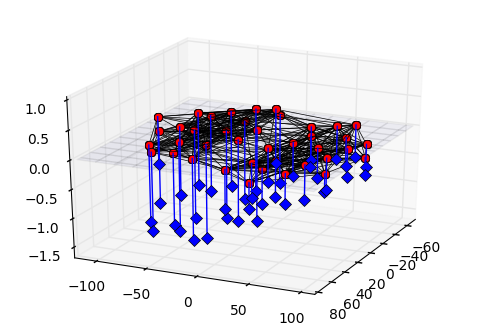

In [7]:
if choice == 'newman' or choice == 'tree':
    pos=nx.circular_layout(G0, dim=2, scale=1.0, center=None)
elif choice == 'grid':
    pos=dict(zip(G0.nodes(), [np.asarray(u) for u in G0.nodes()]))
else:
    pos=nx.nx_pydot.graphviz_layout(G0)
    
pos_coordinate = np.array([[pos[key][0], pos[key][1]] for key in pos])
X0_2, nodeIdx = LSN.get_node_attributes(G0_node)
edge_list = LSN.get_edgelist(G0_node)

view_angle = [25, 25] #[25, 180]
LSN.plot_node_3d(pos_coordinate, edge_list, X0_2, view_angle=view_angle, nodeIdx=nodeIdx, save_fig=savefigure)

##  sparse inverse covariance estimation via glasso

In [8]:
from sklearn import preprocessing
#X0 += np.random.randn(X0.shape[0], X0.shape[1])
X0 -= np.mean(X0, axis=0)
X0 /= X0.std(axis=0)

In [9]:
from Gaussian_network import sparse_inv_cov_glasso 

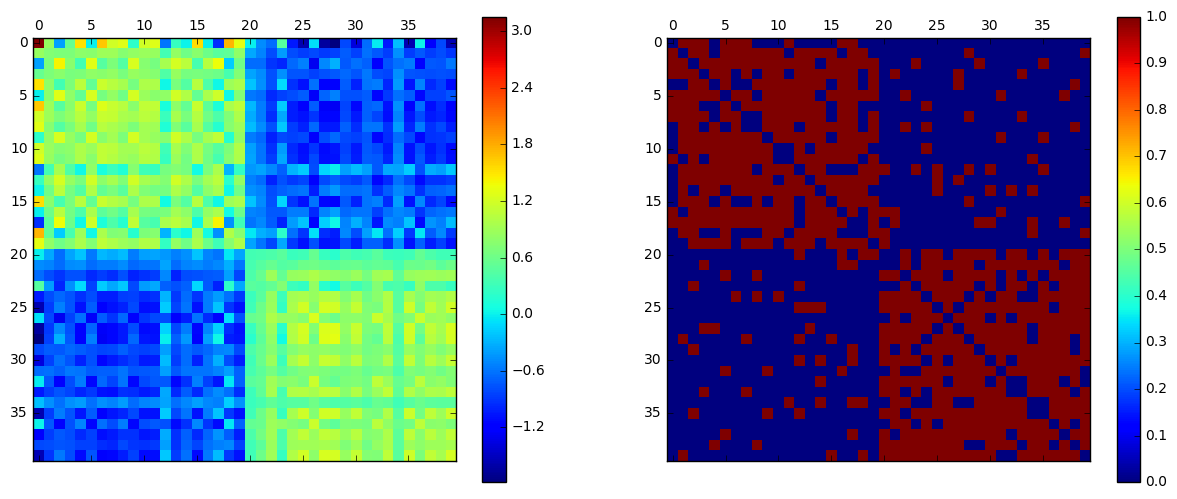

In [10]:
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(np.cov(X0))
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
adjMatSparse =  nx.adjacency_matrix(G0)
adjMat = adjMatSparse.todense()
cax = ax.matshow(adjMat)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_adjmat.eps"
if savefigure : fig2.savefig(filename)

In [12]:
covariance, precision = sparse_inv_cov_glasso(X0, alpha=0.7, max_iter = 100)

The algorithm did not coverge. Try increasing the max number of iterations.


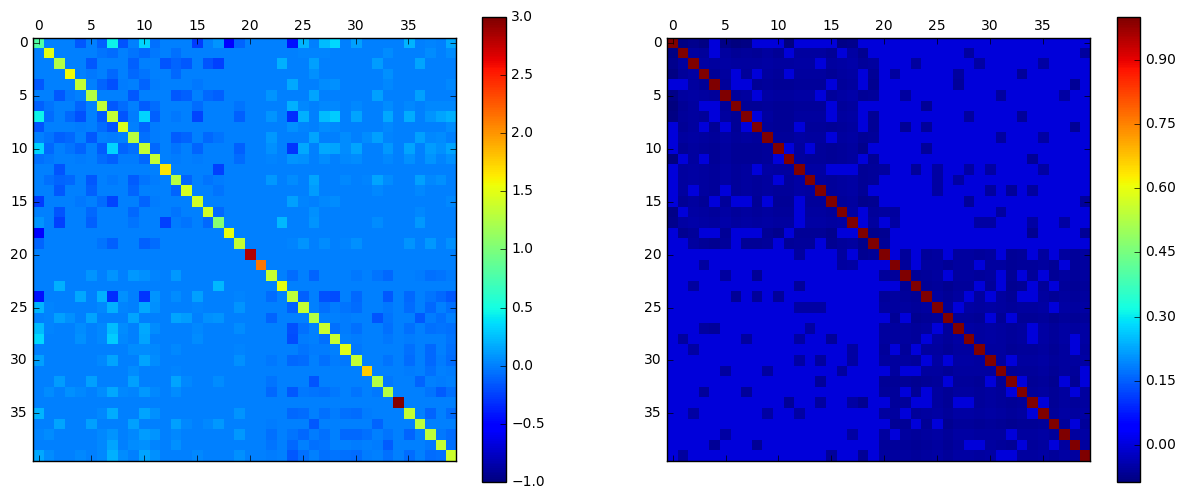

In [13]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(precision, vmin=-1, vmax=3)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)

Laplacian = nx.normalized_laplacian_matrix(G0).todense()
cax = ax.matshow(Laplacian)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
if savefigure : fig2.savefig(filename)

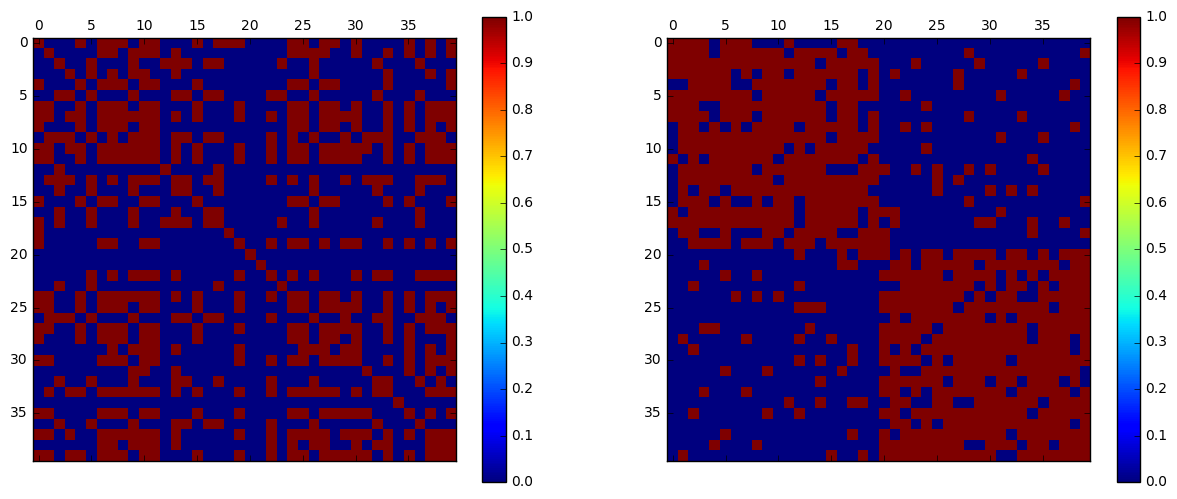

In [14]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(precision)), vmin=0, vmax =1)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
Laplacian = nx.normalized_laplacian_matrix(G0).todense()
cax = ax.matshow(sp.sign(abs(Laplacian)), vmin=0, vmax =1)
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_bin.eps"
if savefigure : fig2.savefig(filename)